# day 2-2

---

## 0. はじめに

ページ上部のメニューバーにある **Kernel** メニューをクリックし、プルダウンメニューから [**Change Kernel ...**] を選び、**gssm2023:Python** を選択してください。

<img src="images/change_kernel1.png" width="30%">

ノートブック上部の右隅に表示されたカーネル名が **gssm2023:Python** になっていることを確認してください。

<img src="images/change_kernel2.png" width="30%">

---

## 3. テキスト解析

### 3.1 形態素解析

#### 3.1.1 MeCab を使う

##### (1) そのまま出力してみる

In [1]:
import MeCab

tagger = MeCab.Tagger("-r ../tools/usr/local/etc/mecabrc")
print(tagger.parse("今日はいい天気です"))

今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



##### (2) 扱いやすいように Pandas の DataFrame に格納する

In [2]:
import pandas as pd

node = tagger.parseToNode("今日はいい天気です")
features = []
while node:
    features.append(node.feature.split(','))
    node = node.next

columns = [
    "品詞",
    "品詞細分類1",
    "品詞細分類2",
    "品詞細分類3",
    "活用型",
    "活用形",
    "基本形",
    "読み",
    "発音",
]
pd.DataFrame(features, columns=columns)

,品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用型,活用形,基本形,読み,発音
0,BOS/EOS,*,*,*,*,*,*,*,*
1,名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
2,助詞,係助詞,*,*,*,*,は,ハ,ワ
3,形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
4,名詞,一般,*,*,*,*,天気,テンキ,テンキ
5,助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
6,BOS/EOS,*,*,*,*,*,*,*,*


### 3.2 係り受け解析

#### 3.2.1 CaboCha を使う

##### (1) そのまま出力してみる

In [3]:
import CaboCha

cp = CaboCha.Parser("-r ../tools/usr/local/etc/cabocharc")
tree = cp.parse("今日はいい天気です")
print(tree.toString(CaboCha.FORMAT_LATTICE))

* 0 2D 0/1 -1.041733
今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.041733
いい	形容詞,自立,*,*,形容詞・イイ,基本形,いい,イイ,イイ
* 2 -1D 0/1 0.000000
天気	名詞,一般,*,*,*,*,天気,テンキ,テンキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS



##### (2) ツリー形式で出力する

In [4]:
print(cp.parseToString("今日はいい天気です"))

  今日は---D
      いい-D
    天気です
EOS



##### (3) 係り受けペアを出力する

In [5]:
# 構文木(tree)からチャンクを取り出す
def get_chunks(tree):
    chunks = {}
    key = 0
    for i in range(tree.size()):
        tok = tree.token(i)
        if tok.chunk:
            chunks[key] = tok.chunk
            key += 1
    return chunks


# チャンク(chunk)から表層形を取り出す
def get_surface(chunk):
    surface = ""
    beg = chunk.token_pos
    end = chunk.token_pos + chunk.token_size
    for i in range(beg, end):
        token = tree.token(i)
        surface += token.surface
    return surface

In [6]:
chunks = get_chunks(tree)

for from_chunk in chunks.values():
    if from_chunk.link < 0:
        continue
    to_chunk = chunks[from_chunk.link]

    from_surface = get_surface(from_chunk)
    to_surface = get_surface(to_chunk)

    print(from_surface, '->', to_surface)

今日は -> 天気です
いい -> 天気です


---

## 4. データ理解

### 4.1 データのダウンロード (1度だけ実行)

以下のデータをダウンロードします

| ファイル名 | 件数 | データセット | 備考 |
| --- | --- | --- | --- |
| rakuten-1000-2022-2023.xlsx.zip | 10,000 | •レジャー+ビジネスの 10エリア<br>•エリアごと 1,000件 (ランダムサンプリング)<br>•期間: 2022/1~2023 GW明け | 本講義の全体を通して使用する |

In [7]:
FILE_ID = "1n-uvGoH7XQhxexN57hYXuFrkGeHKp-HV"
!gdown --id {FILE_ID}
!unzip rakuten-1000-2022-2023.xlsx.zip

### 4.2 データの読み込み (DataFrame型)

In [8]:
import pandas as pd

df = pd.read_excel("rakuten-1000-2022-2023.xlsx")
print(df.shape)
display(df.head())

(10000, 18)


,カテゴリー,エリア,施設番号,施設名,コメント,総合,サービス,立地,部屋,設備・アメニティ,風呂,食事,旅行の目的,同伴者,宿泊年月,投稿者,年代,性別
0,A_レジャー,01_登別,5500,登別 石水亭,お風呂が男女時間交代の屋上風呂に入れなかったのが残念でした。食事はスタッフの皆さんがとても親...,5,5,4,5,5.0,4.0,5.0,レジャー,家族,44743,さとちん4359,60代,女性
1,A_レジャー,01_登別,39175,登別温泉 登別グランドホテル,大浴場のアメニティ、洗い場のクレンジング、ソープ、パック等が充実していて、大変良かったです。...,4,5,4,3,5.0,5.0,5.0,レジャー,家族,44835,まなちゃん5695,60代,女性
2,A_レジャー,01_登別,20547,北湯沢温泉郷 湯元 ホロホロ山荘,犬プラン素泊まり一名で宿泊しましたが、夜8時頃売店でお土産(その時飲む飲み物など)を買う時に...,1,1,2,2,3.0,4.0,NaN,レジャー,一人,44835,投稿者,na,na
3,A_レジャー,01_登別,139962,ザ レイクビュー ＴＯＹＡ 乃の風リゾート,部屋風呂が最高でした。,5,5,5,5,5.0,5.0,5.0,レジャー,恋人,44986,投稿者,na,na
4,A_レジャー,01_登別,80732,登別カルルス温泉 湯元オロフレ荘,カルルス温泉郷の静かな立地、そして湯元の素晴らしい泉質、美味しいお料理、飾らない中にも親切な...,5,5,5,5,5.0,5.0,5.0,レジャー,家族,44986,投稿者,na,na


### 4.3 集計

#### (1) エリア別の件数を表示する

In [9]:
display(df.pivot_table(index=['カテゴリー','エリア'], columns=None, values='コメント', aggfunc='count'))

コメント
カテゴリー  エリア         
A_レジャー 01_登別   1000
       02_草津   1000
       03_箱根   1000
       04_道後   1000
       05_湯布院  1000
B_ビジネス 06_札幌   1000
       07_名古屋  1000
       08_東京   1000
       09_大阪   1000
       10_福岡   1000

サンプリングデータなので、すべて1000件になっていることを確認する

#### (2) 投稿者の傾向 (年代別x性別、全体で100%)

In [10]:
cross_df = pd.crosstab(df['年代'], df['性別'], margins=False, margins_name='合計', normalize=True) * 100
display(cross_df[['男性','女性','na']].style.format('{:.2f}%').bar(axis=None, width=90, height=90, align='left'))

性別,男性,女性,na
年代,,,
10代,0.07%,0.01%,0.00%
20代,0.88%,1.17%,0.00%
30代,2.28%,2.37%,0.00%
40代,5.19%,3.54%,0.00%
50代,7.83%,4.12%,0.00%
60代,4.88%,2.05%,0.00%
70代,1.00%,0.31%,0.00%
80代,0.09%,0.02%,0.00%
na,0.00%,0.00%,64.19%


`na` を除く

In [11]:
display(cross_df[['男性','女性']].style.format('{:.2f}%').bar(axis=None, width=90, height=90, align='left'))

性別,男性,女性
年代,,
10代,0.07%,0.01%
20代,0.88%,1.17%
30代,2.28%,2.37%
40代,5.19%,3.54%
50代,7.83%,4.12%
60代,4.88%,2.05%
70代,1.00%,0.31%
80代,0.09%,0.02%
na,0.00%,0.00%


#### (3) 投稿者の傾向 (性別xカテゴリ別、列ごとで100%)

In [12]:
cross_df = pd.crosstab(df['性別'], df['カテゴリー'], margins=True, margins_name='合計', normalize='columns') * 100
display(cross_df.loc[['男性','女性','na'],:].style.format('{:.2f}%').bar(axis=None, width=90, height=90, align='left'))

カテゴリー,A_レジャー,B_ビジネス,合計
性別,,,
男性,22.26%,22.18%,22.22%
女性,15.22%,11.96%,13.59%
na,62.52%,65.86%,64.19%


`na` を除く

In [13]:
display(cross_df.loc[['男性','女性'],:].style.format('{:.2f}%').bar(axis=None, width=90, height=90, align='left'))

カテゴリー,A_レジャー,B_ビジネス,合計
性別,,,
男性,22.26%,22.18%,22.22%
女性,15.22%,11.96%,13.59%


#### (4) 投稿者の傾向 (性別xエリア別、列ごとで100%)

In [14]:
cross_df = pd.crosstab(df['性別'], [df['カテゴリー'],df['エリア']], margins=True, margins_name='合計', normalize='columns') * 100
display(cross_df.style.format('{:.2f}%'))

カラーバーにすると横に長くなるため、ヒートマップでプロットする

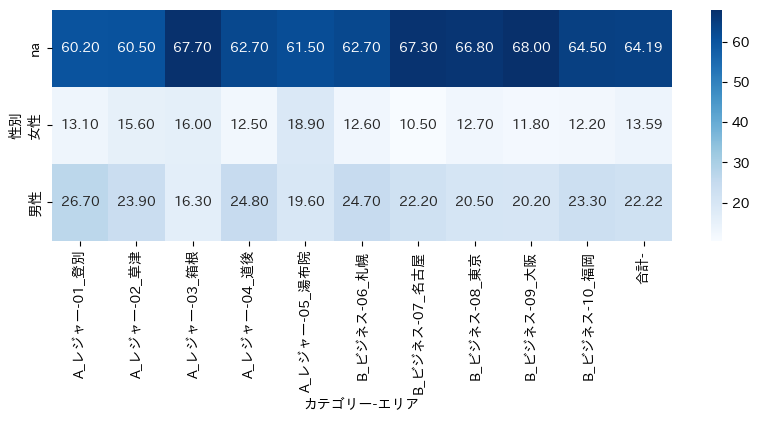

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(10,3))
sns.heatmap(cross_df, annot=True, fmt='.2f', cmap='Blues')
plt.show()

`na` を除いてプロットする

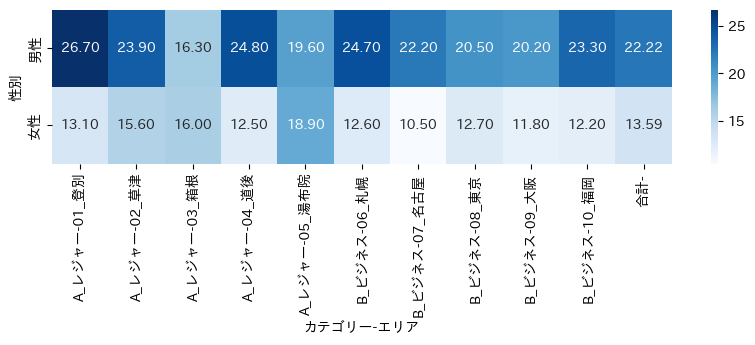

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(10,2))
sns.heatmap(cross_df.loc[['男性','女性'],:], annot=True, fmt='.2f', cmap='Blues')
plt.show()

#### (5) 投稿者の傾向 (年代xエリア別、列ごとで100%)

In [17]:
cross_df = pd.crosstab(df['年代'], [df['カテゴリー'],df['エリア']], margins=True, margins_name='合計', normalize='columns') * 100
display(cross_df.style.format('{:.2f}%'))

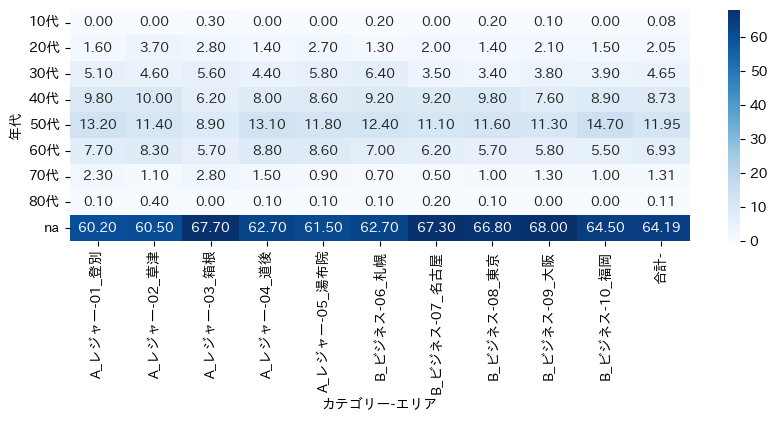

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(10,3))
sns.heatmap(cross_df, annot=True, fmt='.2f', cmap='Blues')
plt.show()

`na` を除いてプロットする

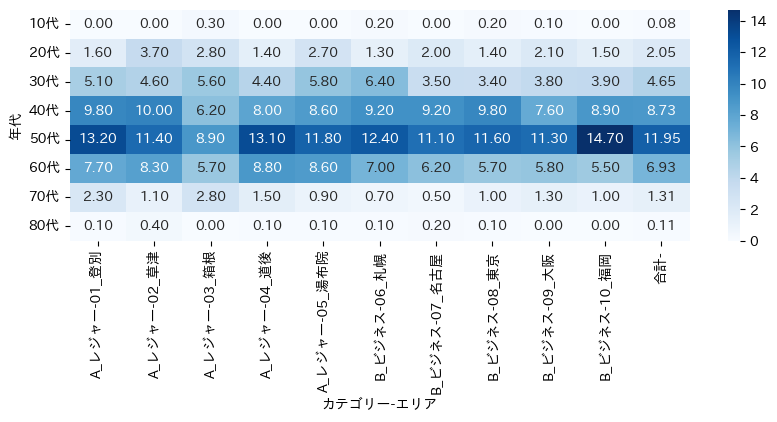

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(10,3))
sns.heatmap(cross_df.loc[cross_df.index!='na',:], annot=True, fmt='.2f', cmap='Blues')
plt.show()

#### (6) 投稿者の傾向 (同伴者別xエリア別、列ごとで100%)

In [20]:
cross_df = pd.crosstab(df['同伴者'], [df['カテゴリー'],df['エリア']], margins=True, margins_name='合計', normalize='columns') * 100
display(cross_df.style.format('{:.2f}%'))

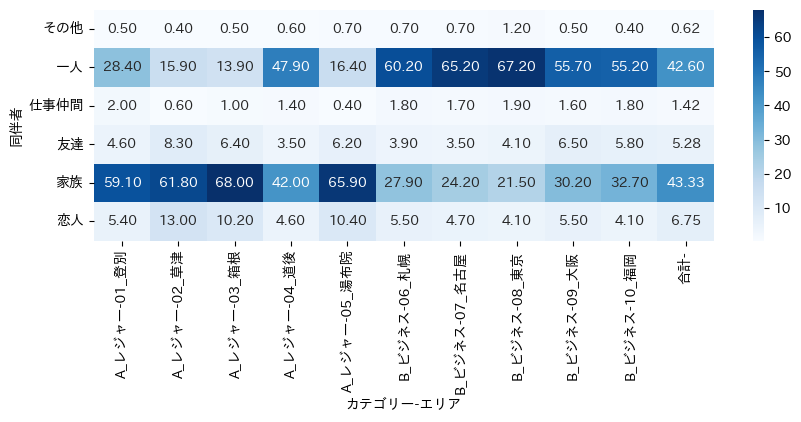

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(10,3))
sns.heatmap(cross_df, annot=True, fmt='.2f', cmap='Blues')
plt.show()

#### (7) 数値評価の構成 (総合別xカテゴリ-エリア別、列ごとに100%)

In [22]:
cross_df = pd.crosstab(df['総合'], [df['カテゴリー'],df['エリア']], margins=True, margins_name='合計', normalize='columns') * 100
display(cross_df.style.format('{:.2f}%'))

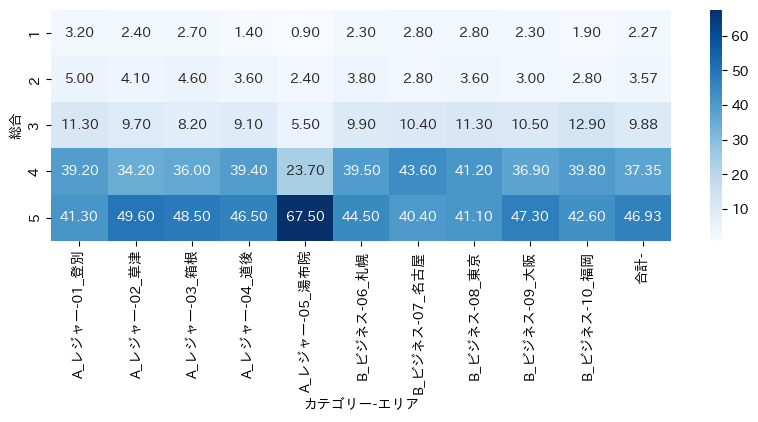

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(10,3))
sns.heatmap(cross_df, annot=True, fmt='.2f', cmap='Blues')
plt.show()

#### (8) 数値評価の平均 (カテゴリ-エリア別x数値評価別)

カテゴリ別

In [24]:
pivot_df = df.pivot_table(index=['カテゴリー','エリア'], values=['サービス','立地','部屋','設備・アメニティ','風呂','食事'], margins=False, aggfunc='mean')
display(pivot_df.style.format('{:.2f}').background_gradient(axis=None))

エリア別

In [25]:
pivot_df = df.pivot_table(index=['カテゴリー'], values=['サービス','立地','部屋','設備・アメニティ','風呂','食事'], margins=True, aggfunc='mean', dropna=False)
display(pivot_df.style.format('{:.2f}').background_gradient(axis=None))

,サービス,立地,設備・アメニティ,部屋,風呂,食事
カテゴリー,,,,,,
A_レジャー,4.22,4.28,4.01,4.11,4.29,4.26
B_ビジネス,4.00,4.34,3.92,4.10,3.82,4.06
All,4.11,4.31,3.96,4.11,4.06,4.18


#### (9)数値評価の平均 (年代x性別)

20~30代

In [26]:
pivot_df = df[df['年代'].isin(['20代','30代'])].pivot_table(index=['カテゴリー','性別'], values=['サービス','立地','部屋','設備・アメニティ','風呂','食事'], margins=False, aggfunc='mean', dropna=False)
display(pivot_df.style.format('{:.2f}').background_gradient(axis=None))

40~50代

In [27]:
pivot_df = df[df['年代'].isin(['40代','50代'])].pivot_table(index=['カテゴリー','性別'], values=['サービス','立地','部屋','設備・アメニティ','風呂','食事'], margins=False, aggfunc='mean', dropna=False)
display(pivot_df.style.format('{:.2f}').background_gradient(axis=None))

60~80代

In [28]:
pivot_df = df[df['年代'].isin(['60代','70代','80代'])].pivot_table(index=['カテゴリー','性別'], values=['サービス','立地','部屋','設備・アメニティ','風呂','食事'], margins=False, aggfunc='mean', dropna=False)
display(pivot_df.style.format('{:.2f}').background_gradient(axis=None))